In [1]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
 

def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn, engine = None, None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            
            engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                user, password, host, port, database
            ))
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return [conn, engine]


In [2]:
[conn, engine] = connect_postgres()

INFO:root:Connected...
INFO:root:Everything goes well from Postgres, you're a fu*** pro...


In [3]:
df_iss = pd.read_sql("""
SELECT
	copytransaction.id, code, trans_tittle_code_id, trans_date_id as date_iss
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date
WHERE
	trans_location_code_id = 5 AND
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3340' AND
    year IN (2000) AND
	trans_type_code IN ('ISS') AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, id

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df_ret = pd.read_sql("""
SELECT
    code, trans_tittle_code_id, trans_date_id as date_ret
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date
WHERE
	trans_location_code_id = 5 AND
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3340' AND
    year IN (2000) AND
	trans_type_code IN ('RET') AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df_iss = df_iss.reset_index(drop=True)
df_iss

,id,code,trans_tittle_code_id,date_iss
0,5885227,199001027,51482,20000405
1,925486,199001027,139079,20000405
2,5885226,199001027,173446,20000405
3,925484,199001027,505748,20000405
4,826521,199101209,113533,20000125
...,...,...,...,...
2909,5943249,201026922,131184,20001020
2910,1064013,201026922,11297,20001124
2911,1015443,201026922,11297,20001201
2912,1033273,201026922,11297,20001104


In [6]:
df_ret = df_ret.reset_index(drop=True)
df_ret

,code,trans_tittle_code_id,date_ret
0,199001027,51482,20000425
1,199001027,139079,20000405
2,199001027,173446,20000131
3,199001027,173446,20000425
4,199001027,505748,20000405
...,...,...,...
2972,201026922,131184,20001024
2973,201026922,11297,20001127
2974,201026922,11297,20001202
2975,201026922,11297,20001107


In [7]:
df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('int64').columns})
df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('bool').columns})
df_iss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 0 to 2913
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   id                    2914 non-null   int32
 1   code                  2914 non-null   int32
 2   trans_tittle_code_id  2914 non-null   int32
 3   date_iss              2914 non-null   int32
dtypes: int32(4)
memory usage: 45.7 KB


In [8]:
df_ret = df_ret.astype({col: 'int32' for col in df_ret.select_dtypes('int64').columns})
df_ret = df_ret.astype({col: 'int32' for col in df_iss.select_dtypes('bool').columns})
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   code                  2977 non-null   int32
 1   trans_tittle_code_id  2977 non-null   int32
 2   date_ret              2977 non-null   int32
dtypes: int32(3)
memory usage: 35.0 KB


In [9]:
# final_DF = df_iss.merge(df_ret, on=['code','trans_copy_code_id'], how = 'inner')

left2 = df_iss.merge(df_ret, how='left', on=['code','trans_tittle_code_id'])
left2['diff'] = left2['date_ret'] - left2['date_iss']
left2 = left2[left2['diff'] >= 0]
left2 = left2.sort_values(
    ['code','trans_tittle_code_id', 'diff']
)
left2

,id,code,trans_tittle_code_id,date_iss,date_ret,diff
0,5885227,199001027,51482,20000405,20000425.0,20.0
1,925486,199001027,139079,20000405,20000405.0,0.0
3,5885226,199001027,173446,20000405,20000425.0,20.0
4,925484,199001027,505748,20000405,20000405.0,0.0
5,826521,199101209,113533,20000125,20000210.0,85.0
...,...,...,...,...,...,...
4810,5943249,201026922,131184,20001020,20001024.0,4.0
4806,1105760,201026922,136114,20001216,20001218.0,2.0
4803,5935086,201026922,136114,20001014,20001019.0,5.0
4804,5935086,201026922,136114,20001014,20001218.0,204.0


In [10]:
left2.columns

Index(['id', 'code', 'trans_tittle_code_id', 'date_iss', 'date_ret', 'diff'], dtype='object')

In [11]:
df = left2.groupby(['code','trans_tittle_code_id', 'id'])[[
    'date_iss', 'date_ret', 'diff'
]].first().reset_index()
df.head(20)

,code,trans_tittle_code_id,id,date_iss,date_ret,diff
0,199001027,51482,5885227,20000405,20000425.0,20.0
1,199001027,139079,925486,20000405,20000405.0,0.0
2,199001027,173446,5885226,20000405,20000425.0,20.0
3,199001027,505748,925484,20000405,20000405.0,0.0
4,199101209,113533,826521,20000125,20000210.0,85.0
5,199101209,374470,878432,20000223,20000223.0,0.0
6,199101209,394126,5872649,20000210,20000225.0,15.0
7,199101244,115635,871311,20000126,20000126.0,0.0
8,199101244,115771,836720,20000127,20000127.0,0.0
9,199101244,316003,850832,20000118,20000126.0,8.0


In [12]:
df['ISS'] = pd.to_datetime(df['date_iss'].astype(str), format='%Y%m%d') 
df['RET'] = pd.to_datetime(df['date_ret'].astype(str), format='%Y%m%d')
df['trans_tittle_code_id'] = df['trans_tittle_code_id'].astype(str)
df['duration'] = df['RET'] - df['ISS'] + pd.Timedelta(days=1)
df['duration'] = df['duration'].dt.days

In [14]:
df_new = df.drop(['date_iss', 'id', 'date_ret', 'diff', 'ISS', 'RET'], axis=1)
df_new = df_new.groupby(['code','trans_tittle_code_id'])['duration'].agg(['sum','count']).reset_index()
df_new['score'] = df_new['sum'] * df_new['count'] 
df_new = df_new.sort_values(by=['score'])
df_new

,code,trans_tittle_code_id,sum,count,score
0,199001027,139079,1,1,1
1002,199709027,128802,1,1,1
1004,199709027,136567,1,1,1
1009,199709027,164682,1,1,1
1010,199709027,341824,1,1,1
...,...,...,...,...,...
1787,199910033,114287,85,6,510
1285,199824036,8173,135,4,540
1279,199824036,33777,136,4,544
90,199304250,494103,309,2,618


In [53]:
df_fav = pd.pivot_table(df_new, values = 'score', index=['code'], columns = 'trans_tittle_code_id', fill_value=0).add_prefix('title_')
df_fav

trans_tittle_code_id,title_100017,title_10006,title_100191,title_100506,title_10059,title_100894,title_100961,title_101032,title_1011,title_101292,...,title_93258,title_940,title_955,title_973,title_97497,title_97613,title_97649,title_9793,title_9945,title_9951
code,,,,,,,,,,,,,,,,,,,,,
199001027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199113169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199115974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200129666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200223011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200243848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [58]:
columns = df_fav.columns
filter_col = [col for col in columns if col.startswith('title_')]

# Since the dummy columns already have values of 0 or 1,
# it is common to exclude them from standardization.
cols_to_standardize = [
  column for column in columns
    if column in filter_col
]

['title_100017', 'title_10006', 'title_100191', 'title_100506', 'title_10059', 'title_100894', 'title_100961', 'title_101032', 'title_1011', 'title_101292', 'title_101793', 'title_102872', 'title_102880', 'title_102885', 'title_102887', 'title_102895', 'title_102905', 'title_102914', 'title_102944', 'title_102947', 'title_102950', 'title_10324', 'title_10335', 'title_1039', 'title_10482', 'title_10508', 'title_105141', 'title_105148', 'title_10632', 'title_10633', 'title_10648', 'title_10702', 'title_1078', 'title_10806', 'title_10825', 'title_10865', 'title_10957', 'title_109911', 'title_110', 'title_11015', 'title_110351', 'title_11041', 'title_1105', 'title_11064', 'title_110659', 'title_111021', 'title_111045', 'title_111173', 'title_111586', 'title_1116', 'title_112075', 'title_11214', 'title_112214', 'title_112436', 'title_112472', 'title_112545', 'title_112781', 'title_11281', 'title_11282', 'title_112949', 'title_11297', 'title_113165', 'title_113420', 'title_113489', 'title_11

In [59]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

data_to_standardize = df_fav[cols_to_standardize]
scaler = StandardScaler().fit(data_to_standardize)

# Standardize the columns.
standardized_data = df_fav.copy()
standardized_columns = scaler.transform(data_to_standardize)
standardized_data[cols_to_standardize] = standardized_columns

standardized_data

trans_tittle_code_id,title_100017,title_10006,title_100191,title_100506,title_10059,title_100894,title_100961,title_101032,title_1011,title_101292,...,title_93258,title_940,title_955,title_973,title_97497,title_97613,title_97649,title_9793,title_9945,title_9951
code,,,,,,,,,,,,,,,,,,,,,
199001027,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
199101209,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
199101244,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
199113169,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
199115974,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200129666,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
200223011,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
200243848,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378


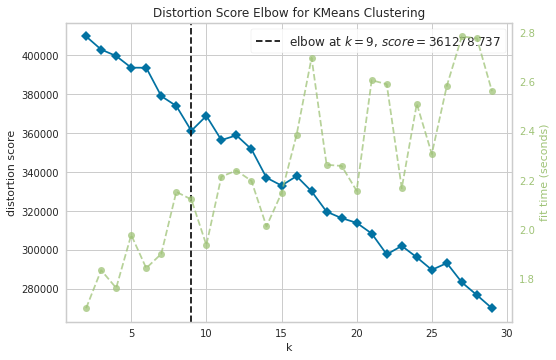

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(init='k-means++', random_state=540)
visualizer = KElbowVisualizer(km, k=(2,30))
 
visualizer.fit(standardized_data)
visualizer.show()

In [63]:
# Train a Kmeans instance
n_clusters = 9

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=540)
kmeans.fit(standardized_data)
clusters = kmeans.predict(standardized_data)
df_fav['cluster'] = clusters


df_fav = df_fav.astype({col: 'int32' for col in df_fav.select_dtypes('int64').columns})
df_fav = df_fav.astype({col: 'int32' for col in df_fav.select_dtypes('float64').columns})
df_fav = df_fav.astype({col: 'int32' for col in df_fav.select_dtypes('bool').columns})

df_fav

trans_tittle_code_id,title_100017,title_10006,title_100191,title_100506,title_10059,title_100894,title_100961,title_101032,title_1011,title_101292,...,title_940,title_955,title_973,title_97497,title_97613,title_97649,title_9793,title_9945,title_9951,cluster
code,,,,,,,,,,,,,,,,,,,,,
199001027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199113169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199115974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200129666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200223011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200243848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

pca = PCA(n_components=2)

reduced_X = pd.DataFrame(pca.fit_transform(standardized_data), columns=["PC1", "PC2"])
reduced_X

,PC1,PC2
0,-0.489559,-0.159376
1,-0.459566,-0.211774
2,-0.481722,-0.147272
3,-0.452997,-0.146099
4,-0.499927,-0.163085
...,...,...
253,-0.463882,-0.150008
254,0.793295,-0.314853
255,-0.452997,-0.146099
256,-0.452179,-0.152470


In [65]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.489559,-0.159376,0
1,-0.459566,-0.211774,0
2,-0.481722,-0.147272,0
3,-0.452997,-0.146099,0
4,-0.499927,-0.163085,0
...,...,...,...
253,-0.463882,-0.150008,0
254,0.793295,-0.314853,0
255,-0.452997,-0.146099,0
256,-0.452179,-0.152470,0


/opt/app/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


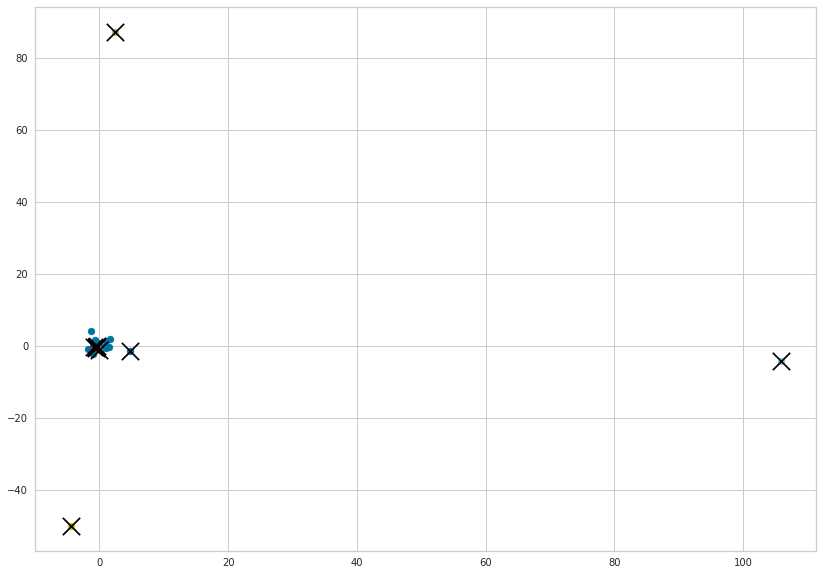

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

reduced_centers = pca.transform(kmeans.cluster_centers_)

for cluster in range(0, n_clusters):
    plt.scatter(
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC1'],
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC2']
    )


plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], color='black', marker='x', s=300)
plt.show()

In [69]:
df_fav['cluster'].value_counts()

0    250
3      1
7      1
4      1
8      1
2      1
1      1
5      1
6      1
Name: cluster, dtype: int64